## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [1]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

## Data Processing

In [2]:
data_root_dp = os.path.join('soccer')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: "soccer"


### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [3]:
import sqlite3

# open connection to .sqlite file
data_sql_fp = os.path.join(data_root_dp, 'database.sqlite')
print(f'will read from: "{data_sql_fp}"')
con = sqlite3.connect(data_sql_fp)

df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
print(f'shape: {df.shape}')
con.close()  # close connection to .sqlite file

# save to .csv
out_fp = os.path.join(data_root_dp, 'player_attributes.csv')
os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
print(f'will save to: "{out_fp}"')
df.to_csv(out_fp, index=False)

will read from: "soccer\database.sqlite"
shape: (183978, 42)
will save to: "soccer\player_attributes.csv"


### read the  data

In [4]:
data_player_attributes_fp = os.path.join(data_root_dp, 'player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "soccer\player_attributes.csv"
(183978, 42)


In [5]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [6]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [7]:
# the dataset we're working with migh get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [8]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

In [9]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key

* so our assumption holds. but let's work only with latest stats for each player

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [10]:
# # your code here

df['new'] = df.groupby(['id'])['date'].transform('max')
df = df.drop(df[df['new'] != df['date']].index)
df = df.drop(columns = 'new')
df


,id,date,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,2016-02-18,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
5,155782,2016-04-21,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,162549,2016-01-07,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,62.0,67.0,77.0,74.0,85.0,51.0,92.0,61.0,65.0,66.0,71.0,57.0,60.0,55.0,64.0,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
64,30572,2016-04-21,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,59.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
87,23780,2015-12-24,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183924,26357,2015-03-06,73.0,73.0,42.0,27.0,74.0,70.0,30.0,54.0,49.0,33.0,53.0,63.0,53.0,63.0,62.0,68.0,62.0,57.0,84.0,54.0,76.0,30.0,75.0,66.0,22.0,52.0,50.0,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0
183937,111182,2014-09-18,63.0,67.0,65.0,44.0,59.0,63.0,49.0,57.0,67.0,64.0,63.0,61.0,69.0,68.0,62.0,65.0,58.0,30.0,68.0,77.0,69.0,31.0,67.0,61.0,49.0,49.0,53.0,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0
183953,36491,2011-02-22,68.0,73.0,64.0,38.0,71.0,66.0,57.0,65.0,60.0,44.0,60.0,67.0,71.0,73.0,59.0,69.0,72.0,59.0,42.0,70.0,68.0,53.0,78.0,64.0,58.0,66.0,61.0,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0
183960,35506,2011-02-22,67.0,78.0,48.0,43.0,79.0,59.0,59.0,36.0,29.0,37.0,51.0,61.0,66.0,66.0,56.0,62.0,53.0,50.0,68.0,68.0,67.0,46.0,71.0,67.0,28.0,63.0,45.0,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0


In [11]:
print(df.shape)

(11060, 37)


In [12]:
assert df.duplicated(['id']).sum() == 0
assert df.shape == (11060, 37)

In [13]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

### NaNs

In [14]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

* do you see any pattern in how NaNs are distributed?

In [15]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

#### Task 2. Drop rows that contain NaNs (1 point)

In [16]:
df = df.dropna()
df

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
5,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,62.0,67.0,77.0,74.0,85.0,51.0,92.0,61.0,65.0,66.0,71.0,57.0,60.0,55.0,64.0,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
64,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,59.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
87,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183924,73.0,73.0,42.0,27.0,74.0,70.0,30.0,54.0,49.0,33.0,53.0,63.0,53.0,63.0,62.0,68.0,62.0,57.0,84.0,54.0,76.0,30.0,75.0,66.0,22.0,52.0,50.0,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0
183937,63.0,67.0,65.0,44.0,59.0,63.0,49.0,57.0,67.0,64.0,63.0,61.0,69.0,68.0,62.0,65.0,58.0,30.0,68.0,77.0,69.0,31.0,67.0,61.0,49.0,49.0,53.0,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0
183953,68.0,73.0,64.0,38.0,71.0,66.0,57.0,65.0,60.0,44.0,60.0,67.0,71.0,73.0,59.0,69.0,72.0,59.0,42.0,70.0,68.0,53.0,78.0,64.0,58.0,66.0,61.0,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0
183960,67.0,78.0,48.0,43.0,79.0,59.0,59.0,36.0,29.0,37.0,51.0,61.0,66.0,66.0,56.0,62.0,53.0,50.0,68.0,68.0,67.0,46.0,71.0,67.0,28.0,63.0,45.0,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0


In [17]:
assert df.isna().sum().sum() == 0

## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{true} = (\hat{y}_{true}^{(0)}, \hat{y}_{true}^{(1)}, ..., \hat{y}_{true}^{(n)}) $,
  
  where $ \ \ \hat{y}_{true}^{(i)} = max(\ \ | y_{true}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{true}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

In [18]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true, y_pred):
    #raise NotImplementedError()
    #value_mse = sum([(y_t - y_p)**2 for y_t, y_p in zip(y_true, y_pred)])/len(y_true) без библиотеки numpy
    value_mse = np.mean(np.square(y_true - y_pred))
    return value_mse
    
def mae(*, y_true, y_pred):
    #value_mae = sum([abs(y_t - y_p) for y_t, y_p in zip(y_true, y_pred)])/len(y_true) без библиотеки numpy
    value_mae = np.mean(np.abs(y_true - y_pred))
    return value_mae
    #raise NotImplementedError()
    
def mape(*, y_true, y_pred):
    y_true_max = []
    eps = np.finfo(np.float64).eps
    for i in y_true:  
        y_true_max.append(max(i, eps ))
    value_mape = np.mean(np.abs((y_true - y_pred)/y_true_max))
    return value_mape
    #raise NotImplementedError()
    
def r2(*, y_true, y_pred):
    y = np.mean(y_true)
    SSresiduals = np.sum(np.square(y_true - y_pred))
    SStotal = np.sum(np.square(y_true - y))
    if SSresiduals != 0 and SStotal != 0:
        value_r2 = 1-SSresiduals/SStotal
        return value_r2
    elif SSresiduals != 0 and SStotal == 0:
        return 0
    else:
        return 1
    #raise NotImplementedError()

### Validate your implementations are correct

* we'll use synthetic data for this task


In [19]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [20]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    """ Print and compare values of custom and library functions using given precision. """
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

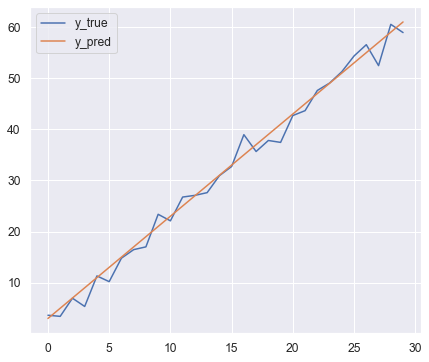

In [21]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [22]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 3.51191323882697
mse library: 3.51191323882697

mae custom : 1.4089037570441607
mae library: 1.4089037570441607

mape custom : 0.08620163828800183
mape library: 0.08620163828800183

r2 custom : 0.9885526699424528
r2 library: 0.9885526699424528

all tests passed


#### 0s in target. MAPE should explode

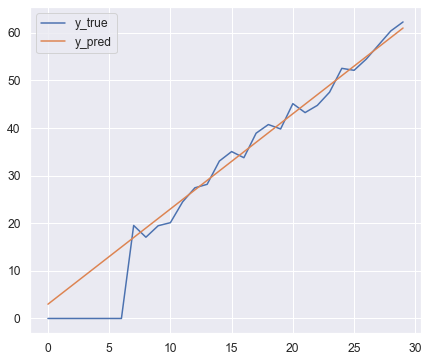

In [23]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [24]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 24.697607316187536
mse library: 24.697607316187536

mae custom : 3.2493430554899145
mae library: 3.2493430554899145

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.9402887912122584
r2 library: 0.9402887912122584

all tests passed


#### edge cases for R2

In [25]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 0
r2 library: 0.0

success


In [26]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


### Define helper functions

In [27]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    """ A helper function to return all metrics for given labels and predictions. """
    
    # if you didn't implement some metrics, comment them out for this function to work.
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [28]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    """ 
    A helper function to: 
    * fit a passed model
    * and return metrics on train and test sets.
    """
    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [29]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


In [30]:
def get_train_test_data(features: List[str], target: str) -> tuple:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [31]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's visualize our data first

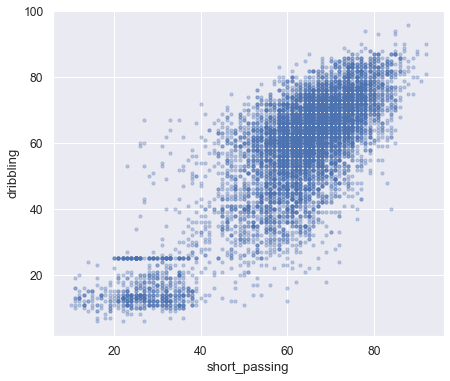

In [32]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.xlabel('short_passing');
plt.ylabel('dribbling');

* do you notice anything interesting on this plot?
* if so, how can we use it later to generate more accurate predictions?

### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [33]:
pd.Series.corr(df['short_passing'],df['dribbling'])

0.8129375578604559

### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [36]:
model_intercept = model.intercept_
model_slope = model.coef_[0]
print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.211029905025974
model_slope: 1.0366141627766239


* use fitted model to get predictions for test set

In [37]:
model_preds = model.predict(x_test)
model_preds

array([55.98581986, 65.31534733, 44.58306407, ..., 62.20550484,
       54.9492057 , 76.71810312])

* explore model quality on test set.

In [38]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_1

model metrics on test set


mse     108.345801
mae       8.173553
mape      0.205500
r2        0.681477
dtype: float64

* can you explain what those metic values mean?

#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [39]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.
# your code here:
model_manual_preds = model_intercept + model_slope*x_test

In [40]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [41]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

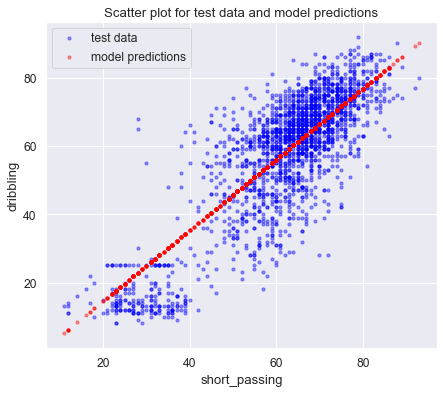

In [42]:
# # your code here
# plt.scatter(...)
# plt.scatter(...)
# plt.legend(...);  # adds legend to a plot
plt.title('Scatter plot for test data and model predictions')
plt.scatter(x=x_test, y=y_test, alpha=0.4, s=10 , color='blue');
plt.scatter(x=x_test, y=model_manual_preds, alpha=0.4, s=10, color='red');
plt.legend(['test data','model predictions'])
plt.xlabel('short_passing');
plt.ylabel('dribbling');

### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) y_i}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [43]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [44]:
# # your code here:
manual_slope = np.sum((x-np.mean(x))*y)/np.sum(np.square(x-np.mean(x)))
manual_intercept = np.mean(y) - manual_slope*np.mean(x)


In [45]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.211029905026017
manual_slope: 1.0366141627766245


In [46]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [47]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's explore the data first

In [48]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

,ball_control,short_passing,strength,sprint_speed,dribbling
ball_control,1.000000,0.904857,-0.024422,0.572677,0.919271
short_passing,0.904857,1.000000,0.039196,0.450801,0.809405
strength,-0.024422,0.039196,1.000000,-0.203386,-0.150197
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.656453
dribbling,0.919271,0.809405,-0.150197,0.656453,1.000000


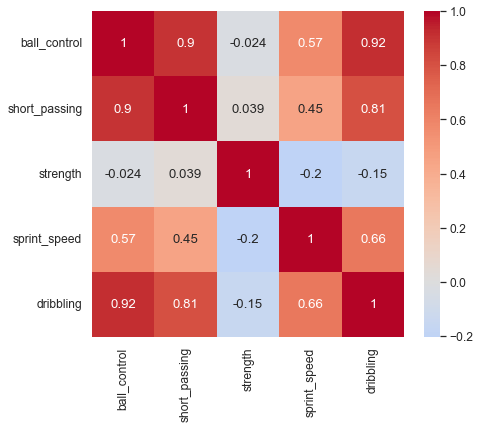

In [49]:
# # your code here
correlation_matrix = DF_TRAIN[cols].corr()
display(correlation_matrix)
sns.heatmap(correlation_matrix, center = 0, annot=True, cmap = 'coolwarm');

* what can you say about selected feature set using this correlation matrix?

#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

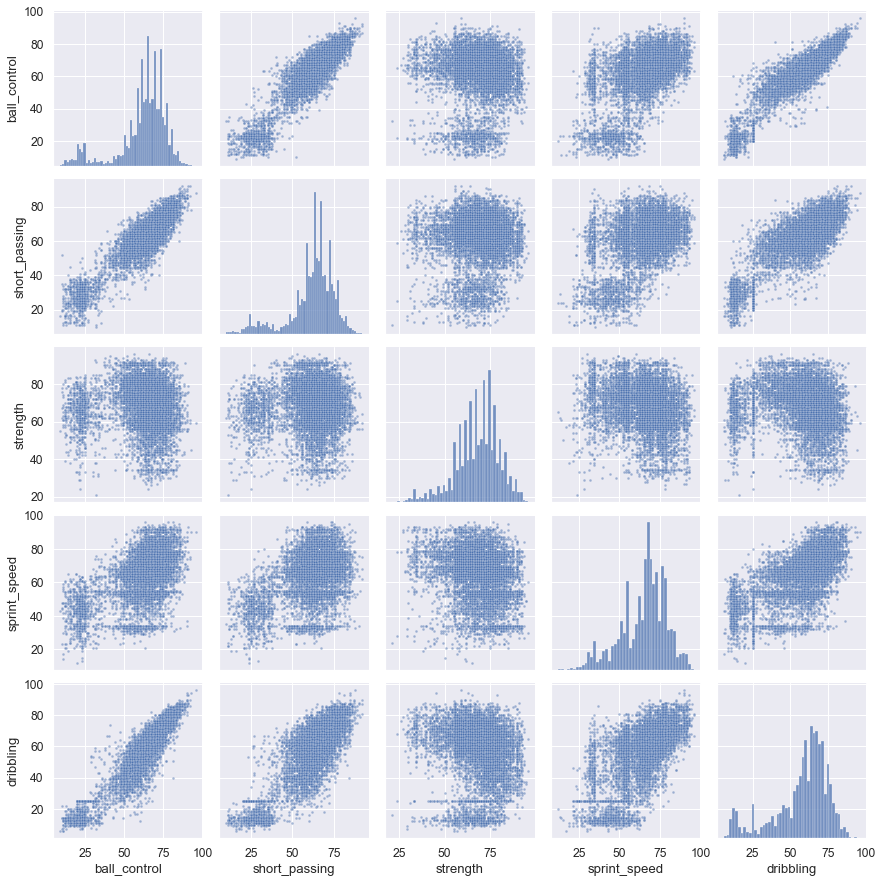

In [50]:
sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5});

* what can you say about these scatterplots? is there anything we can use later?

 ### Solve using `sklearn`

In [51]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [52]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: -4.410760994496613
model_coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


* how to interpret these model parameters?

* use fitted model to get predictions for test set

In [53]:
model_preds = model.predict(x_test)
model_preds

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* explore model quality on test set.

In [54]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     38.192447
mae      4.459334
mape     0.112574
r2       0.887719
dtype: float64

* Let's compare `metrics_test_2` against `metrics_test_1`

In [55]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

,mse,mae,mape,r2
LR_1v,108.345801,8.173553,0.205500,0.681477
LR_mv,38.192447,4.459334,0.112574,0.887719


C:\Users\VVV\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


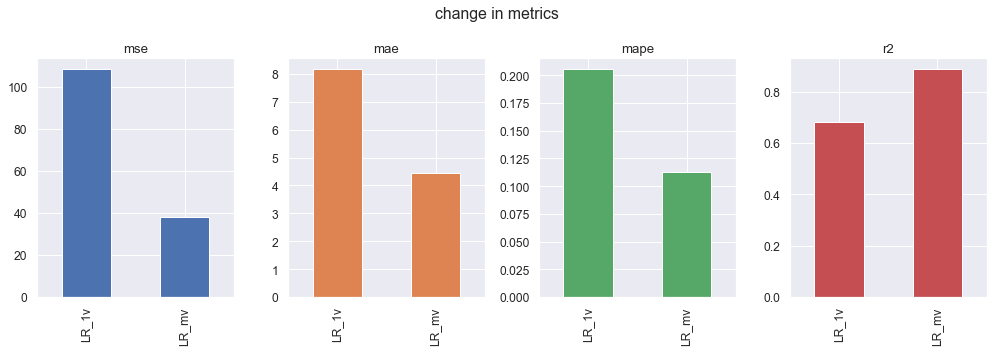

In [56]:
fig, ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='change in metrics', legend=False, ax=ax
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

* did our Linear regression model improve after we've added more features?

### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

**<TL;DR\>** Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

In [57]:
x_train.to_numpy().shape

(8465, 4)

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [58]:
from sklearn.exceptions import NotFittedError

In [59]:
def add_ones_column(x):
    """ 
    Add column consisting of ones to the beginning of matrix `x`. 
    Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    """
    # HINTS: 
    # * create a vector that consists of ones: (1, 1, ..., 1)
    # * then use either `np.column_stack` or `np.hstack` function to add this vector to a matrix
    vector_one= np.ones(x.shape[0])
    x = np.column_stack((vector_one,x))
    return x
    # # your code here:
    # return ...

class LRMatrixForm:
    """
    Class that encapsulates Linear regression model with multiplie variables.
    Calculations are performed using matrix formula.
    
    Use `fit()` method to fit the model on data.
    Use `predict()` method to calculate predictions when the model is fitted.
    """
    def __init__(self, fit_intercept: bool = True):
        """
        fit_intercept: 
        Whether to calculate the intercept for this model. 
        If set to False, no intercept will be used in calculations 
        (i.e. data is expected to be centered).
        """
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)
            
        # # your code here to calculate model parameters:
        self.w_ = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y_train)
    
    @property
    def coef_(self):
        """ Property that returns model parameters without the intercept term. """
        if self.w_ is None:
            raise NotFittedError()
        if self.fit_intercept is True:
            return self.w_[1:]  
        else:
            return self.w_
        # # your code here:
        # return ...
    
    @property
    def intercept_(self):
        """ Property that returns intercept term from model parameters. """
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
            
        return self.w_[0]
        # # your code here:
        # return ...
    
    def predict(self, x_test: pd.DataFrame):
        """ Generate predictions using fitted model parameters. """
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)
            
        Y_predict=X.dot(self.w_)
        return Y_predict
        # return ...

### Validate your implementation is identical to library version

In [60]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744076,4.423665,0.109928,0.879145
test,38.192447,4.459334,0.112574,0.887719


In [61]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -4.410760994495639
coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


In [62]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

In [63]:
model.predict(x_test)

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* let's take a look at difference between model predictions and target values:

In [64]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean       -0.000265
std         6.181464
min       -19.832055
25%        -3.624840
50%        -0.929033
75%         2.657819
max        39.721074
Name: dribbling, dtype: float64

### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [65]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


In [66]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


* Compare the metrics on a test set of a model fitted **with** intercept parameter 
  vs model fitted **without** intercept.
* Which model has a better performance? Can you explain why?

In [67]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.99382995 -0.05758452 -0.17865978  0.18315944]


In [68]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [69]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.069583
std         6.199275
min       -20.437460
25%        -3.706841
50%        -0.888994
75%         2.766454
max        39.316868
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [70]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [71]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    """ 
    Construct new column as a linear transform of another one + tiny noise.
    y = f(x) = a1 * x + a2 + noise.
    
    Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    And only add some noise to existing column. Results would be the same.
    """
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [72]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.9999999999936515


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [73]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_wo_noise'] = 2 * check['sprint_speed'] + 3
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,sprint_speed_2_wo_noise
72296,77.0,70.0,83.0,55.0,113.000009,113.0
60549,55.0,60.0,76.0,54.0,111.000000,111.0
51472,61.0,62.0,73.0,49.0,100.999768,101.0
59690,65.0,57.0,84.0,70.0,143.000063,143.0
21580,73.0,70.0,73.0,75.0,152.999905,153.0


### let's fit a Linear Regression model on this feature set:

In [74]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.731191,4.424645,0.109906,0.879187
test,38.171928,4.461795,0.112612,0.887779


* Both train and test metrics look reasonable
* Now let's explore model params:

In [75]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

intercept: 3429.5853809822493
coef: [0.9825997105529645, -0.039483115956893536, -0.1445136987211811, 2289.524939858947, -1144.6587872835335]


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [76]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds
147541,51.0,60.0,68.0,52.0,107.000083,49.0,44.213545
147549,65.0,69.0,66.0,69.0,140.999792,59.0,61.762023


In [77]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     15.269463
mae      3.774239
mape     0.072248
r2       0.389221
dtype: float64

* predictions look good, right? 

### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [78]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2
147541,51.0,60.0,68.0,53.0,107.000083,49.0,44.213545,2333.738484
147549,65.0,69.0,66.0,70.0,140.999792,59.0,61.762023,2351.286963


In [79]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     5.237305e+06
mae     2.288513e+03
mape    4.273982e+01
r2     -2.094912e+05
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [80]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2,preds_3
147541,51.0,60.0,68.0,53.0,109.000083,49.0,44.213545,2333.738484,44.420910
147549,65.0,69.0,66.0,70.0,142.999792,59.0,61.762023,2351.286963,61.969388


* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)


* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion?

### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [81]:
def l2_norm(arr: Iterable):
    L2 = np.sqrt(sum(np.square(arr)))
    return L2
    # your code here
    #raise NotImplementedError()

### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [82]:
l2_norm(model.coef_)

2559.7205272230094

### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [83]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

,mse,mae,mape,r2
train,37.743533,4.423715,0.109923,0.879147
test,38.205505,4.460146,0.112603,0.887681


intercept: 1158.235880849543
coef: [0.9821874528901133, -0.03923797937680022, 232.38519362898154, 232.73727147480838, -232.52957382989467]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [84]:
l2_norm(model.coef_)

402.79086966916464

#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

,ball_control,short_passing,strength,sprint_speed,foo
ball_control,1.000000,0.904857,-0.024422,0.572677,0.474099
short_passing,0.904857,1.000000,0.039196,0.450801,0.415056
strength,-0.024422,0.039196,1.000000,-0.203386,0.541851
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.712702
foo,0.474099,0.415056,0.541851,0.712702,1.000000


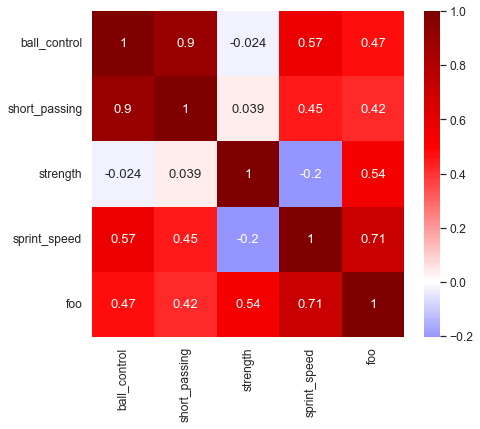

In [85]:
# # your code here
correlation_matrix = x_train.corr()
display(correlation_matrix)
sns.heatmap(correlation_matrix, center = 0, annot=True, cmap = 'seismic');

### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [86]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [87]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.743533,4.423715,0.109923,0.879147
test,38.205505,4.460146,0.112603,0.887681


In [88]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 1158.235880849543
coef: [0.9821874528901136, -0.03923797937679113, 232.38519362898063, 232.73727147480744, -232.52957382989376]
l2 norm: 402.79086966916304


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [89]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744073,4.423665,0.109928,0.879145
test,38.192481,4.459336,0.112574,0.887719


In [90]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -1.2295108166654316
coef: [0.9822051451405541, -0.0392775322222258, 0.4918417823613312, 0.8439789538367444, -0.636250604011966]
l2 norm: 1.5248912473285998


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

Разделим наши данные на обучающие и тестовые в новой пропорции: 70% - обучающие данные и 30% тестовые.

In [91]:
ix_split = int(0.7 * df.shape[0])
data_train = df.iloc[:ix_split].copy()
data_test = df.iloc[ix_split:].copy()

Проверим наше разделение

In [92]:
print(data_train.shape, data_test.shape)

(7407, 35) (3175, 35)


Произведем выбор начального набора признаков для построения обучающей модели.

В качестве начального набора признаков возьмем те признаки, от которых по логике должен зависеть наш целевой признак 'agility' и рассмотрим их далее. В результате анализа мы выбрали 12 признаков.


In [93]:
col_feateres = ['acceleration','jumping','sprint_speed', 'dribbling','ball_control', 'short_passing','crossing','volleys', 'curve', 'finishing','balance','reactions']

In [94]:
target = 'agility'
features = col_feateres
features

['acceleration',
 'jumping',
 'sprint_speed',
 'dribbling',
 'ball_control',
 'short_passing',
 'crossing',
 'volleys',
 'curve',
 'finishing',
 'balance',
 'reactions']

Построим матрицу корреляции для выбранных признаков.

,acceleration,jumping,sprint_speed,dribbling,ball_control,short_passing,crossing,volleys,curve,finishing,balance,reactions,agility
acceleration,1.000000,0.212250,0.909341,0.680446,0.582372,0.456805,0.570323,0.465796,0.516787,0.495660,0.650941,0.178649,0.800293
jumping,0.212250,1.000000,0.230436,0.059365,0.093569,0.081420,0.055750,0.025434,0.014702,0.020906,0.178288,0.228493,0.191620
sprint_speed,0.909341,0.230436,1.000000,0.655600,0.570658,0.449081,0.554994,0.447975,0.486093,0.479489,0.567371,0.174338,0.733033
dribbling,0.680446,0.059365,0.655600,1.000000,0.918540,0.809678,0.825405,0.782282,0.817182,0.784504,0.605007,0.317949,0.711282
ball_control,0.582372,0.093569,0.570658,0.918540,1.000000,0.904499,0.823977,0.751873,0.807772,0.732182,0.552797,0.384052,0.625286
short_passing,0.456805,0.081420,0.449081,0.809678,0.904499,1.000000,0.802589,0.644577,0.749726,0.598785,0.488406,0.406242,0.517836
crossing,0.570323,0.055750,0.554994,0.825405,0.823977,0.802589,1.000000,0.645841,0.816720,0.590064,0.576377,0.323022,0.614506
volleys,0.465796,0.025434,0.447975,0.782282,0.751873,0.644577,0.645841,1.000000,0.751440,0.870025,0.439412,0.348653,0.540948
curve,0.516787,0.014702,0.486093,0.817182,0.807772,0.749726,0.816720,0.751440,1.000000,0.698224,0.541547,0.355061,0.610468
finishing,0.495660,0.020906,0.479489,0.784504,0.732182,0.598785,0.590064,0.870025,0.698224,1.000000,0.420727,0.299517,0.547516


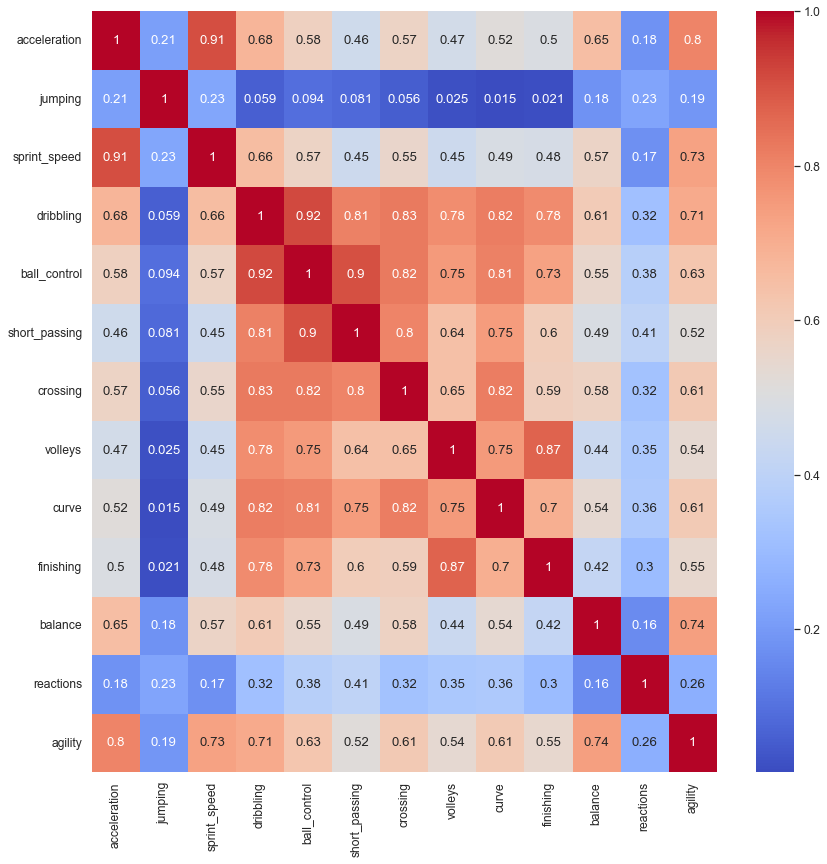

In [95]:
correlation_matrix = data_train[features+[target]].corr()
display(correlation_matrix)
plt.figure(figsize=(14,14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm');

Проанализировав матрицу корреляции и тепловую карту, мы можем увидеть наличие пар признаков, имеющих высокую корреляцию. На практике пороговое значение корреляции пар признаков зависит от задач обучающей модели и находится в диапазоне от 0,7 до 1 (для начала выберем порог от 0,85 и посмотрим на результат нашей модели). Это такие пары как:
* 'acceleration' и 'sprint_speed' - мы удалим 'sprint_speed' так как корреляция между данным признаком и целевой переменной меньше.
* 'dribbling' и 'ball_control' - мы удалим 'ball_control' по той же причине (корреляция между данным признаком и целевой переменной меньше).
* 'ball_control' и 'short_passing	' - так как мы уже удалили 'ball_control', проблема в данной паре уже решена.


In [96]:
for i in ['sprint_speed', 'ball_control']:
    features.remove(i)
print(features)

['acceleration', 'jumping', 'dribbling', 'short_passing', 'crossing', 'volleys', 'curve', 'finishing', 'balance', 'reactions']


Построим нашу обучающею модель и рассчитаем показатели для обучающих и тестовых наборов.

In [97]:
def get_train_test_data1(features: List[str], target: str) -> tuple:
    return (
        data_train[features].copy(), data_train[target].copy(), 
        data_test[features].copy(), data_test[target].copy()
    )

In [98]:
x_train, y_train, x_test, y_test = get_train_test_data1(features, target)
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,45.452610,5.131499,0.091399,0.757562
test,49.650207,5.309392,0.095509,0.748346


Произведем анализ производительности полученной  модели.

In [99]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: 0.4656328658801172
model_coef: [ 0.42190735  0.02680505  0.142152   -0.09535545 -0.01479923  0.00270431
  0.07921225  0.01724658  0.32591108  0.10963454]


In [100]:
l2_norm(model.coef_)

0.5771137671659552

На основании рассчитаных параметров мы можем предположить, что наша модель не переобучена. Так как коэффициент L2 norm достаточно мал и составляет 0.57.

Так как основные показатели регрессии имеют высокие значения относительно нуля (особенно показатель MSE = 50.3 для тестовой выборки) попробуем улучшить нашу модель.

В первом построении нашей обучающей модели мы использовали последовательное семплирование. Попробуем данные взять рандомно.

In [101]:
ix_split = int(0.7 * df.shape[0])
data_train_new = df.sample(ix_split)
ind_data_test = df.index.drop(data_train_new.index)
data_test_new = df.loc[ind_data_test]
data_train_new

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
76942,60.0,72.0,29.0,19.0,56.0,41.0,20.0,40.0,23.0,26.0,38.0,46.0,65.0,73.0,59.0,56.0,54.0,25.0,74.0,56.0,70.0,23.0,56.0,61.0,26.0,31.0,32.0,60.0,65.0,62.0,11.0,13.0,16.0,7.0,9.0
99154,73.0,73.0,64.0,25.0,75.0,67.0,58.0,51.0,63.0,41.0,69.0,59.0,63.0,68.0,59.0,71.0,56.0,61.0,83.0,71.0,77.0,31.0,74.0,73.0,53.0,56.0,38.0,72.0,74.0,71.0,11.0,6.0,14.0,12.0,14.0
44698,62.0,69.0,63.0,31.0,53.0,62.0,46.0,56.0,53.0,46.0,57.0,61.0,71.0,66.0,83.0,63.0,91.0,48.0,87.0,67.0,34.0,38.0,73.0,58.0,53.0,55.0,37.0,66.0,60.0,61.0,10.0,6.0,15.0,7.0,11.0
53775,65.0,65.0,66.0,37.0,56.0,61.0,39.0,60.0,59.0,58.0,61.0,63.0,66.0,70.0,74.0,68.0,61.0,63.0,82.0,63.0,62.0,41.0,67.0,66.0,33.0,32.0,47.0,64.0,67.0,68.0,12.0,13.0,14.0,11.0,14.0
117827,75.0,81.0,40.0,21.0,79.0,68.0,20.0,42.0,21.0,29.0,63.0,63.0,51.0,56.0,41.0,69.0,48.0,77.0,69.0,63.0,78.0,36.0,81.0,80.0,44.0,33.0,41.0,75.0,74.0,78.0,12.0,11.0,10.0,11.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183408,73.0,78.0,67.0,70.0,66.0,71.0,73.0,75.0,63.0,64.0,55.0,77.0,72.0,72.0,77.0,75.0,69.0,77.0,67.0,68.0,68.0,65.0,45.0,25.0,76.0,66.0,71.0,20.0,34.0,24.0,7.0,5.0,11.0,9.0,10.0
119135,72.0,86.0,27.0,16.0,68.0,67.0,28.0,54.0,29.0,21.0,55.0,64.0,68.0,64.0,63.0,67.0,44.0,35.0,78.0,68.0,77.0,36.0,75.0,69.0,27.0,32.0,33.0,76.0,74.0,74.0,10.0,7.0,14.0,7.0,15.0
74008,74.0,82.0,75.0,52.0,52.0,74.0,47.0,76.0,73.0,39.0,68.0,74.0,78.0,82.0,73.0,73.0,81.0,68.0,73.0,77.0,65.0,65.0,66.0,71.0,64.0,65.0,50.0,71.0,77.0,77.0,14.0,11.0,11.0,10.0,10.0
98537,72.0,80.0,47.0,51.0,71.0,75.0,42.0,70.0,59.0,48.0,74.0,73.0,73.0,76.0,65.0,70.0,63.0,77.0,81.0,83.0,83.0,66.0,74.0,69.0,69.0,68.0,57.0,66.0,70.0,69.0,9.0,12.0,9.0,7.0,14.0


In [102]:
data_test_new

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
373,64.0,71.0,41.0,33.0,74.0,57.0,24.0,30.0,35.0,40.0,45.0,44.0,60.0,61.0,59.0,58.0,73.0,48.0,75.0,64.0,71.0,39.0,71.0,58.0,28.0,61.0,39.0,62.0,61.0,57.0,15.0,14.0,13.0,10.0,12.0
392,64.0,69.0,47.0,29.0,65.0,57.0,36.0,47.0,27.0,45.0,55.0,52.0,62.0,67.0,65.0,64.0,59.0,57.0,64.0,65.0,65.0,37.0,67.0,59.0,23.0,52.0,42.0,64.0,65.0,62.0,11.0,5.0,15.0,10.0,10.0
394,73.0,75.0,65.0,17.0,66.0,64.0,24.0,51.0,23.0,23.0,56.0,63.0,68.0,66.0,50.0,68.0,59.0,59.0,73.0,64.0,74.0,38.0,85.0,72.0,48.0,52.0,32.0,75.0,76.0,77.0,9.0,11.0,10.0,8.0,9.0
456,63.0,72.0,42.0,52.0,39.0,64.0,40.0,72.0,67.0,45.0,56.0,67.0,75.0,78.0,82.0,62.0,72.0,48.0,65.0,62.0,53.0,52.0,40.0,23.0,46.0,64.0,46.0,32.0,33.0,40.0,8.0,13.0,8.0,15.0,8.0
465,63.0,63.0,57.0,53.0,58.0,69.0,57.0,59.0,69.0,68.0,66.0,64.0,65.0,67.0,71.0,67.0,70.0,67.0,57.0,62.0,57.0,61.0,58.0,47.0,63.0,67.0,57.0,47.0,39.0,37.0,8.0,15.0,16.0,9.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183551,69.0,76.0,67.0,66.0,48.0,68.0,67.0,71.0,61.0,72.0,56.0,71.0,76.0,75.0,82.0,67.0,71.0,70.0,72.0,50.0,41.0,67.0,47.0,24.0,66.0,69.0,64.0,39.0,32.0,26.0,8.0,9.0,8.0,10.0,10.0
183649,64.0,73.0,67.0,60.0,59.0,69.0,57.0,68.0,44.0,49.0,67.0,66.0,75.0,76.0,77.0,65.0,59.0,67.0,64.0,62.0,62.0,63.0,59.0,22.0,66.0,59.0,60.0,21.0,25.0,25.0,13.0,11.0,15.0,7.0,14.0
183672,89.0,89.0,76.0,90.0,76.0,84.0,92.0,87.0,80.0,80.0,76.0,90.0,72.0,74.0,86.0,85.0,41.0,93.0,72.0,75.0,93.0,88.0,84.0,20.0,86.0,83.0,91.0,15.0,41.0,27.0,13.0,15.0,10.0,9.0,12.0
183867,66.0,72.0,37.0,17.0,78.0,52.0,19.0,39.0,30.0,25.0,48.0,52.0,52.0,53.0,35.0,48.0,41.0,46.0,61.0,60.0,85.0,39.0,76.0,56.0,19.0,38.0,47.0,66.0,69.0,61.0,13.0,14.0,8.0,8.0,14.0


Мы видим, что наши данные разделились рандомно в соотношении 70% -обучающие и 30% - тестовые.

Рассчитаем корреляцию всех признаков относительно нашей целевой переменной и отсортируем его по убыванию.

In [103]:
colir= df.corr().abs().unstack().sort_values(kind="quicksort",ascending = False)
col_new=colir['agility'].index[1:].to_list() # занесли в список название параметров.
colir['agility']

agility               1.000000
acceleration          0.797346
balance               0.742262
sprint_speed          0.730343
dribbling             0.713123
ball_control          0.625814
positioning           0.620826
crossing              0.618485
curve                 0.611963
long_shots            0.555267
finishing             0.553901
vision                0.550416
volleys               0.547171
short_passing         0.521943
free_kick_accuracy    0.503993
stamina               0.482563
shot_power            0.463734
penalties             0.459486
long_passing          0.426705
strength              0.408930
gk_reflexes           0.402946
gk_diving             0.402478
gk_positioning        0.402400
gk_handling           0.398713
gk_kicking            0.397502
potential             0.267011
reactions             0.252051
overall_rating        0.215998
jumping               0.185940
heading_accuracy      0.089995
marking               0.085376
aggression            0.055090
standing

Создадим новый список, в который занесем параметры из старого проверяя на высокую корреляцию между ними с помощью написанной функцией drop_collinearity. Параметры будем рассматривать от самой высокой корреляции относительно целевой переменной до самой низкой.

In [104]:
def drop_collinearity(col_new):
    col = []
    for i in col_new:
        if len(col) == 0: # заносим первый аргумент который имеет макс корреляцию с целевой переменной в новый список
            col.append(i)
        else:
            collinearity = False
            for j in col: # перед занесением параметра в список сравниваем его с параметрами в списке на предмет коллинеарности.
                if pd.Series.corr(df[i],df[j]) >= 0.8: # если корреляция больше 0.8 мы не заносим данный элемент в список.
                    collinearity = True
                    break
            if not collinearity:
                col.append(i)
    return col

In [105]:
col_feateres_new = drop_collinearity(col_new) 
col_feateres_new

['acceleration',
 'balance',
 'dribbling',
 'finishing',
 'vision',
 'free_kick_accuracy',
 'stamina',
 'shot_power',
 'penalties',
 'long_passing',
 'strength',
 'gk_reflexes',
 'potential',
 'reactions',
 'jumping',
 'heading_accuracy',
 'marking',
 'aggression']

Построим матрицу корреляции для выбранных признаков.

,acceleration,balance,dribbling,finishing,vision,free_kick_accuracy,stamina,shot_power,penalties,long_passing,strength,gk_reflexes,potential,reactions,jumping,heading_accuracy,marking,aggression,agility
acceleration,1.000000,0.653479,0.681213,0.502010,0.420443,0.389749,0.547498,0.437027,0.392876,0.340088,-0.305191,-0.446301,0.293930,0.173978,0.212365,0.149663,-0.041966,0.088690,0.792447
balance,0.653479,1.000000,0.611224,0.432240,0.503705,0.472897,0.399166,0.388970,0.402572,0.432589,-0.478745,-0.416831,0.159940,0.153923,0.181956,0.049661,0.031416,0.102712,0.742253
dribbling,0.681213,0.611224,1.000000,0.790789,0.741584,0.724761,0.584731,0.766551,0.725629,0.666295,-0.154546,-0.703592,0.322746,0.305650,0.059097,0.443822,0.075913,0.287378,0.712034
finishing,0.502010,0.432240,0.790789,1.000000,0.679919,0.658039,0.381246,0.748903,0.796067,0.421869,-0.089951,-0.517225,0.250447,0.298856,0.017399,0.388899,-0.249929,0.105288,0.557073
vision,0.420443,0.503705,0.741584,0.679919,1.000000,0.718097,0.440453,0.659621,0.667566,0.693340,-0.122132,-0.456441,0.359204,0.442107,0.010021,0.285425,0.038339,0.249227,0.559181
free_kick_accuracy,0.389749,0.472897,0.724761,0.658039,0.718097,1.000000,0.425784,0.718679,0.716780,0.672186,-0.105593,-0.542428,0.213917,0.321706,-0.023164,0.334678,0.110095,0.286598,0.508163
stamina,0.547498,0.399166,0.584731,0.381246,0.440453,0.425784,1.000000,0.530796,0.393389,0.551241,0.134153,-0.609010,0.239501,0.254443,0.252366,0.495100,0.417618,0.536179,0.478622
shot_power,0.437027,0.388970,0.766551,0.748903,0.659621,0.718679,0.530796,1.000000,0.755695,0.627891,0.130602,-0.659578,0.282754,0.343418,0.094833,0.583265,0.146166,0.436633,0.464383
penalties,0.392876,0.402572,0.725629,0.796067,0.667566,0.716780,0.393389,0.755695,1.000000,0.513427,-0.013125,-0.568642,0.224997,0.308030,0.034316,0.472282,-0.043581,0.246891,0.464047
long_passing,0.340088,0.432589,0.666295,0.421869,0.693340,0.672186,0.551241,0.627891,0.513427,1.000000,0.023986,-0.602118,0.333878,0.378552,0.061308,0.451236,0.492184,0.515985,0.425560


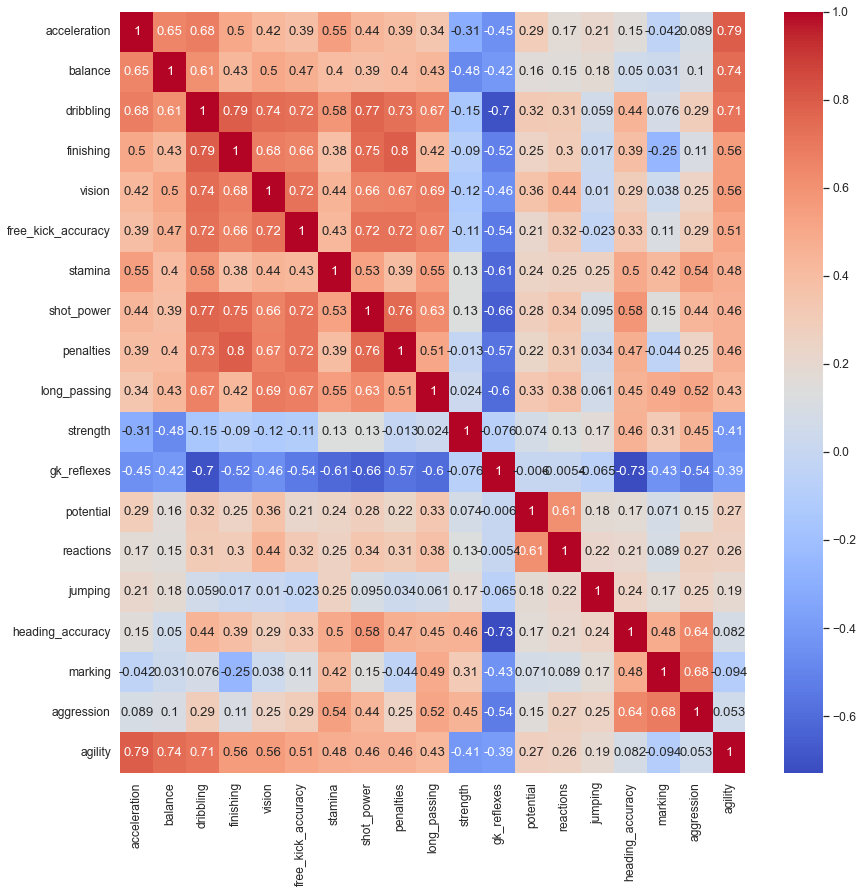

In [106]:
correlation_matrix = data_train_new[col_feateres_new+[target]].corr()
display(correlation_matrix)
plt.figure(figsize=(14,14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm');

Проанализировав матрицу корреляции и тепловую карту, мы можем увидеть что мы избавились от наличия пар признаков, имеющих высокую корреляцию. Признаки 'potential', 'reactions', 'jumping', 'heading_accuracy',	'marking' и 'aggression' имеют очень слабую корреляцию с целевой переменной. Попробуем объединить их и посмотри как измениться корреляция.
* 'potential' и 'reactions' - объединим эти признаки вместе так как их корреляция состовляет 0.61;
* 'heading_accuracy' и 'aggression' - корреляция между данным признаком 0.63;
* 'marking' и 'aggression' - корреляция между данным признаком 0.68.

In [107]:
data_train_new['potential_reactions'] = data_train_new['potential'] * data_train_new['reactions']
data_train_new['heading_accuracy_aggression'] = data_train_new['heading_accuracy'] * data_train_new['aggression']
data_train_new['marking_aggression'] = data_train_new['marking'] * data_train_new['aggression']

In [108]:
data_train_new

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,potential_reactions,heading_accuracy_aggression,marking_aggression
76942,60.0,72.0,29.0,19.0,56.0,41.0,20.0,40.0,23.0,26.0,38.0,46.0,65.0,73.0,59.0,56.0,54.0,25.0,74.0,56.0,70.0,23.0,56.0,61.0,26.0,31.0,32.0,60.0,65.0,62.0,11.0,13.0,16.0,7.0,9.0,4032.0,3136.0,3360.0
99154,73.0,73.0,64.0,25.0,75.0,67.0,58.0,51.0,63.0,41.0,69.0,59.0,63.0,68.0,59.0,71.0,56.0,61.0,83.0,71.0,77.0,31.0,74.0,73.0,53.0,56.0,38.0,72.0,74.0,71.0,11.0,6.0,14.0,12.0,14.0,5183.0,5550.0,5328.0
44698,62.0,69.0,63.0,31.0,53.0,62.0,46.0,56.0,53.0,46.0,57.0,61.0,71.0,66.0,83.0,63.0,91.0,48.0,87.0,67.0,34.0,38.0,73.0,58.0,53.0,55.0,37.0,66.0,60.0,61.0,10.0,6.0,15.0,7.0,11.0,4347.0,3869.0,4818.0
53775,65.0,65.0,66.0,37.0,56.0,61.0,39.0,60.0,59.0,58.0,61.0,63.0,66.0,70.0,74.0,68.0,61.0,63.0,82.0,63.0,62.0,41.0,67.0,66.0,33.0,32.0,47.0,64.0,67.0,68.0,12.0,13.0,14.0,11.0,14.0,4420.0,3752.0,4288.0
117827,75.0,81.0,40.0,21.0,79.0,68.0,20.0,42.0,21.0,29.0,63.0,63.0,51.0,56.0,41.0,69.0,48.0,77.0,69.0,63.0,78.0,36.0,81.0,80.0,44.0,33.0,41.0,75.0,74.0,78.0,12.0,11.0,10.0,11.0,13.0,5589.0,6399.0,6075.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183408,73.0,78.0,67.0,70.0,66.0,71.0,73.0,75.0,63.0,64.0,55.0,77.0,72.0,72.0,77.0,75.0,69.0,77.0,67.0,68.0,68.0,65.0,45.0,25.0,76.0,66.0,71.0,20.0,34.0,24.0,7.0,5.0,11.0,9.0,10.0,5850.0,2970.0,900.0
119135,72.0,86.0,27.0,16.0,68.0,67.0,28.0,54.0,29.0,21.0,55.0,64.0,68.0,64.0,63.0,67.0,44.0,35.0,78.0,68.0,77.0,36.0,75.0,69.0,27.0,32.0,33.0,76.0,74.0,74.0,10.0,7.0,14.0,7.0,15.0,5762.0,5100.0,5700.0
74008,74.0,82.0,75.0,52.0,52.0,74.0,47.0,76.0,73.0,39.0,68.0,74.0,78.0,82.0,73.0,73.0,81.0,68.0,73.0,77.0,65.0,65.0,66.0,71.0,64.0,65.0,50.0,71.0,77.0,77.0,14.0,11.0,11.0,10.0,10.0,5986.0,3432.0,4686.0
98537,72.0,80.0,47.0,51.0,71.0,75.0,42.0,70.0,59.0,48.0,74.0,73.0,73.0,76.0,65.0,70.0,63.0,77.0,81.0,83.0,83.0,66.0,74.0,69.0,69.0,68.0,57.0,66.0,70.0,69.0,9.0,12.0,9.0,7.0,14.0,5600.0,5254.0,4884.0


,acceleration,balance,dribbling,finishing,vision,free_kick_accuracy,stamina,shot_power,penalties,long_passing,strength,gk_reflexes,potential,reactions,jumping,heading_accuracy,marking,aggression,agility,potential_reactions,heading_accuracy_aggression,marking_aggression
acceleration,1.000000,0.653479,0.681213,0.502010,0.420443,0.389749,0.547498,0.437027,0.392876,0.340088,-0.305191,-0.446301,0.293930,0.173978,0.212365,0.149663,-0.041966,0.088690,0.792447,0.246935,0.043999,-0.047127
balance,0.653479,1.000000,0.611224,0.432240,0.503705,0.472897,0.399166,0.388970,0.402572,0.432589,-0.478745,-0.416831,0.159940,0.153923,0.181956,0.049661,0.031416,0.102712,0.742253,0.172156,-0.008095,0.014101
dribbling,0.681213,0.611224,1.000000,0.790789,0.741584,0.724761,0.584731,0.766551,0.725629,0.666295,-0.154546,-0.703592,0.322746,0.305650,0.059097,0.443822,0.075913,0.287378,0.712034,0.345457,0.304386,0.085049
finishing,0.502010,0.432240,0.790789,1.000000,0.679919,0.658039,0.381246,0.748903,0.796067,0.421869,-0.089951,-0.517225,0.250447,0.298856,0.017399,0.388899,-0.249929,0.105288,0.557073,0.309757,0.196052,-0.209169
vision,0.420443,0.503705,0.741584,0.679919,1.000000,0.718097,0.440453,0.659621,0.667566,0.693340,-0.122132,-0.456441,0.359204,0.442107,0.010021,0.285425,0.038339,0.249227,0.559181,0.453132,0.228534,0.067725
free_kick_accuracy,0.389749,0.472897,0.724761,0.658039,0.718097,1.000000,0.425784,0.718679,0.716780,0.672186,-0.105593,-0.542428,0.213917,0.321706,-0.023164,0.334678,0.110095,0.286598,0.508163,0.306180,0.267403,0.121738
stamina,0.547498,0.399166,0.584731,0.381246,0.440453,0.425784,1.000000,0.530796,0.393389,0.551241,0.134153,-0.609010,0.239501,0.254443,0.252366,0.495100,0.417618,0.536179,0.478622,0.276264,0.504643,0.443383
shot_power,0.437027,0.388970,0.766551,0.748903,0.659621,0.718679,0.530796,1.000000,0.755695,0.627891,0.130602,-0.659578,0.282754,0.343418,0.094833,0.583265,0.146166,0.436633,0.464383,0.350338,0.498758,0.205024
penalties,0.392876,0.402572,0.725629,0.796067,0.667566,0.716780,0.393389,0.755695,1.000000,0.513427,-0.013125,-0.568642,0.224997,0.308030,0.034316,0.472282,-0.043581,0.246891,0.464047,0.303553,0.326092,-0.006928
long_passing,0.340088,0.432589,0.666295,0.421869,0.693340,0.672186,0.551241,0.627891,0.513427,1.000000,0.023986,-0.602118,0.333878,0.378552,0.061308,0.451236,0.492184,0.515985,0.425560,0.398133,0.476890,0.496839


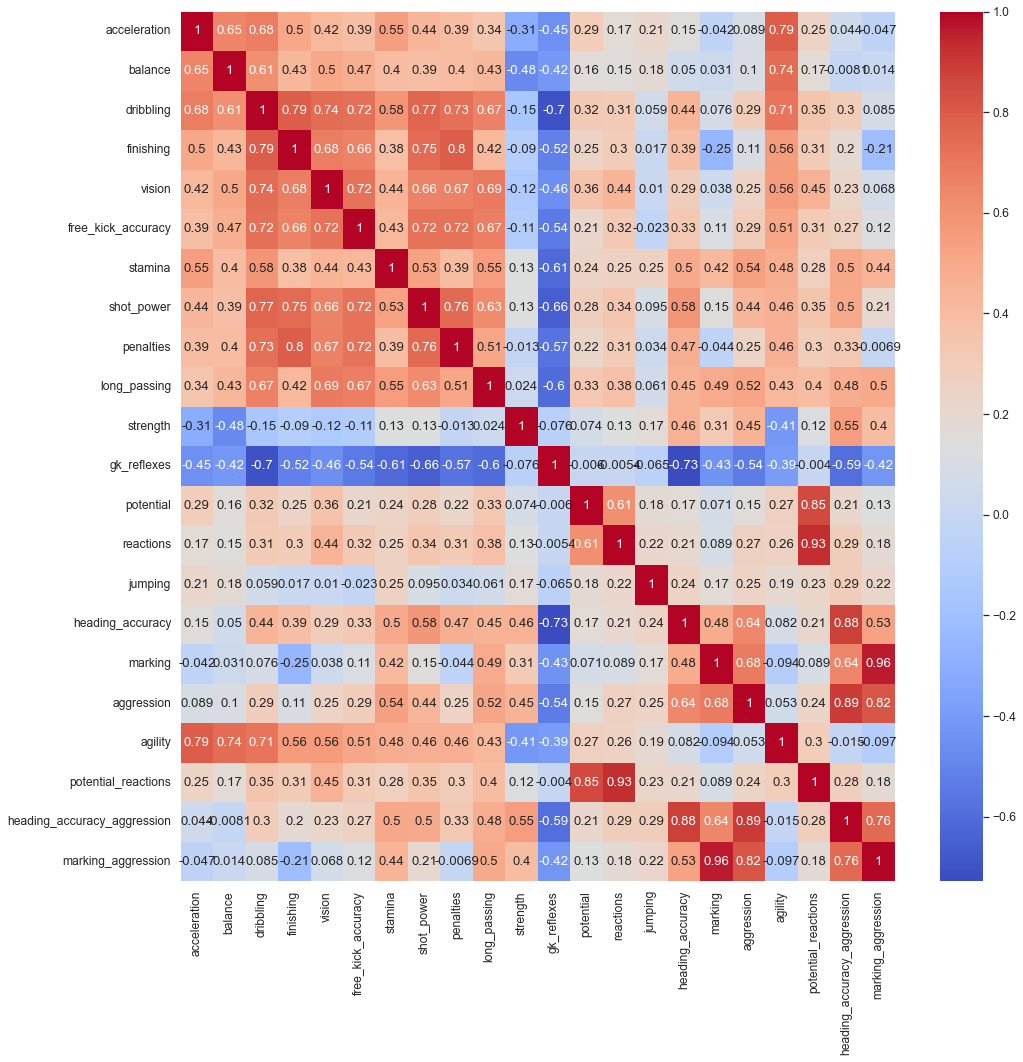

In [109]:
correlation_matrix = data_train_new[col_feateres_new+[target] + ['potential_reactions', 'heading_accuracy_aggression','marking_aggression']].corr()
display(correlation_matrix)
plt.figure(figsize=(16,16))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm');

После объединения нескольких признаков, корреляция относительно целевой переменной увеличилась не значительно. Удалим признаки  'potential', 'reactions', 'jumping', 'heading_accuracy', 'marking' и 'aggression' из списка, так как они коррелируют с новыми признаками, и занесем новые.

In [110]:
feateres = col_feateres_new

In [111]:
for i in [ 'potential', 'reactions', 'jumping', 'heading_accuracy', 'marking', 'aggression' ]:
    feateres.remove(i)
feateres += ['potential_reactions','heading_accuracy_aggression','marking_aggression']
print(feateres)

['acceleration', 'balance', 'dribbling', 'finishing', 'vision', 'free_kick_accuracy', 'stamina', 'shot_power', 'penalties', 'long_passing', 'strength', 'gk_reflexes', 'potential_reactions', 'heading_accuracy_aggression', 'marking_aggression']


In [112]:
col_feateres_new

['acceleration',
 'balance',
 'dribbling',
 'finishing',
 'vision',
 'free_kick_accuracy',
 'stamina',
 'shot_power',
 'penalties',
 'long_passing',
 'strength',
 'gk_reflexes',
 'potential_reactions',
 'heading_accuracy_aggression',
 'marking_aggression']

Добавим новые признаки в тестовый набор.

In [113]:
data_test_new['potential_reactions'] = data_test_new['potential'] * data_test_new['reactions']
data_test_new['heading_accuracy_aggression'] = data_test_new['heading_accuracy'] * data_test_new['aggression']
data_test_new['marking_aggression'] = data_test_new['marking'] * data_test_new['aggression']

Построим модель

In [114]:
def get_train_test_data_new(features: List[str], target: str) -> tuple:
    return (
        data_train_new[features].copy(), data_train_new[target].copy(), 
        data_test_new[features].copy(), data_test_new[target].copy()
    )

In [115]:
x_train, y_train, x_test, y_test = get_train_test_data_new(feateres, target)
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,43.330528,4.976809,0.089264,0.77106
test,43.526825,5.074897,0.091453,0.77453


In [116]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: 9.592911226694312
model_coef: [ 3.75631617e-01  2.63102399e-01  1.54492014e-01  1.88509560e-04
  5.28226123e-02  3.32165088e-02  9.12618942e-02 -2.72482515e-03
 -1.56735948e-02  2.02250670e-02 -1.24606805e-01  6.94774805e-02
  7.31195114e-04 -4.11487407e-06 -6.72087214e-04]


In [117]:
l2_norm(model.coef_)

0.5171355743940869

Для интереса посмотрим какие значения метрик и коэффициента L2_norm мы бы получили если бы не объединяли параметры и не удалили их.

In [118]:
feateres = drop_collinearity(col_new) 
print(feateres)

['acceleration', 'balance', 'dribbling', 'finishing', 'vision', 'free_kick_accuracy', 'stamina', 'shot_power', 'penalties', 'long_passing', 'strength', 'gk_reflexes', 'potential', 'reactions', 'jumping', 'heading_accuracy', 'marking', 'aggression']


In [119]:
def get_train_test_data_new(features: List[str], target: str) -> tuple:
    return (
        data_train_new[features].copy(), data_train_new[target].copy(), 
        data_test_new[features].copy(), data_test_new[target].copy()
    )

In [120]:
x_train, y_train, x_test, y_test = get_train_test_data_new(feateres, target)
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,41.978606,4.894017,0.087616,0.778203
test,42.153774,5.005773,0.090063,0.781642


In [121]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: 11.407358113821985
model_coef: [ 0.36227165  0.22181545  0.17604928 -0.00282784  0.05180208  0.0322409
  0.07934865 -0.0074722  -0.01666273  0.03433739 -0.14057314  0.02645927
 -0.05625043  0.11129222  0.10175028 -0.04516219 -0.06021818 -0.00949235]


In [122]:
l2_norm(model.coef_)

0.5244958634909018

Из полученных метрик двух моделей можно сделать вывод, что модель, где мы не производили объединение признаков и удаление получилась лучше. 

Несмотря на то, что некоторые признаки слабо коррелируют с целевой переменной, вместе они дали хороший результат. Данная модель является лучшей из выше рассматриваемых. 


In [123]:
y_test.head(10)

373    59.0
392    65.0
394    50.0
456    82.0
465    71.0
500    76.0
554    78.0
578    79.0
655    87.0
675    74.0
Name: agility, dtype: float64

In [124]:
model.predict(x_test)[:10]

array([57.26866336, 58.66792384, 59.83043367, 75.71762878, 68.10845337,
       70.74839137, 79.87542491, 73.70942207, 83.4206344 , 71.80228915])

In [125]:
(y_test- model.predict(x_test)).describe()

count    3175.000000
mean       -0.005982
std         6.493614
min       -25.941728
25%        -3.937739
50%         0.220057
75%         4.126686
max        23.600256
Name: agility, dtype: float64

Мы видим что наша модель не переобучилась по следующим признакам: 
* небольшой коэффициент L2_norm;
* небольшие веса коэффициентов;
* мы видим из рассчетов что предсказаные значения близки к реальным.

В данной работе мы создали модель линейной регрессии для прогнозирования параметра ловкости футболиста ('agility'). В результате мы сделали следующие пункты:
* 1) разделили наборы данных на обучающею модель и тестовую 2 способами (рандомно и последовательно);
* 2) выбрали параметры для нашей модели несколькими способами;
* 3) построили корреляционные матрицы;
* 4) избавились от мультиколлинеарности;
* 5) построили модели линейной регрессии и выбрали лучшую.  В результате остановились на таких параметрах как 'acceleration', 'balance', 'dribbling', 'finishing', 'vision', 'free_kick_accuracy', 'stamina', 'shot_power', 'penalties', 'long_passing', 'strength', 'gk_reflexes', 'potential', 'reactions', 'jumping', 'heading_accuracy', 'marking', 'aggressio.

Ответы на следующие вопросы:
* Можете ли вы найти логическое объяснение высокой корреляции некоторых ваших функций? (Некоторые параметры футболистов очень зависят друг от друга и из-за этого мы и наблюдаем высокую корреляцию);
* Удовлетворены ли вы качеством прогнозов? (Прогноз получился не плохой, метрики и коэффициент L2_norm не большие);
* Как вы могли бы потенциально улучшить модель? (Мы могли бы воспользоваться методом регулизации (L1 и L2), так же можно посмотреть, как поведет себя модель если сделать нормализацию данных. При выборе параметров отталкивается от  взаимной информацией а не от корреляции.
